# Third Assignment: Options

# Step 1 - show the price for asset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance
import scipy.stats as stats

[*********************100%***********************]  1 of 1 completed

<Axes: xlabel='Date'>

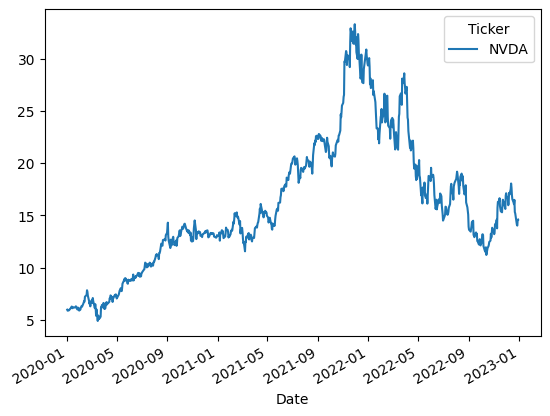

In [78]:
ticker = 'NVDA'
data = yfinance.download(ticker, start='2020-01-01', end='2023-01-01')['Close']
data.plot()

# Step 2 - calculate with Black Scholes

In [79]:
def black_scholes(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")
    
    return price

In [80]:
T = 1
r = 0.01
sigma = 0.2

bs_call_prices = []
bs_put_prices = []

prices = data.values
dates = data.index[1:]

for i in range(1, len(data)):
    S = prices[i - 1]
    K = prices[i]

    bs_call_prices.append(black_scholes(S, K, T, r, sigma, 'call'))
    bs_put_prices.append(black_scholes(S, K, T, r, sigma, 'put'))

In [81]:
def plot_line_chart(ax, x_data, y_data, title, xlabel, ylabel, color, line_width=2):
    ax.plot(x_data, y_data, color=color, linewidth=line_width)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)

def plot_option_prices(dates, call_prices, put_prices, title="Option Prices Over Time"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
    plot_line_chart(ax1, dates, call_prices, 'Call Option Prices', 'Date', 'Price','blue')
    plot_line_chart(ax2, dates, put_prices, 'Put Option Prices', 'Date', 'Price','red')
    plt.tight_layout()
    plt.show()

# Step 3 - display options prices

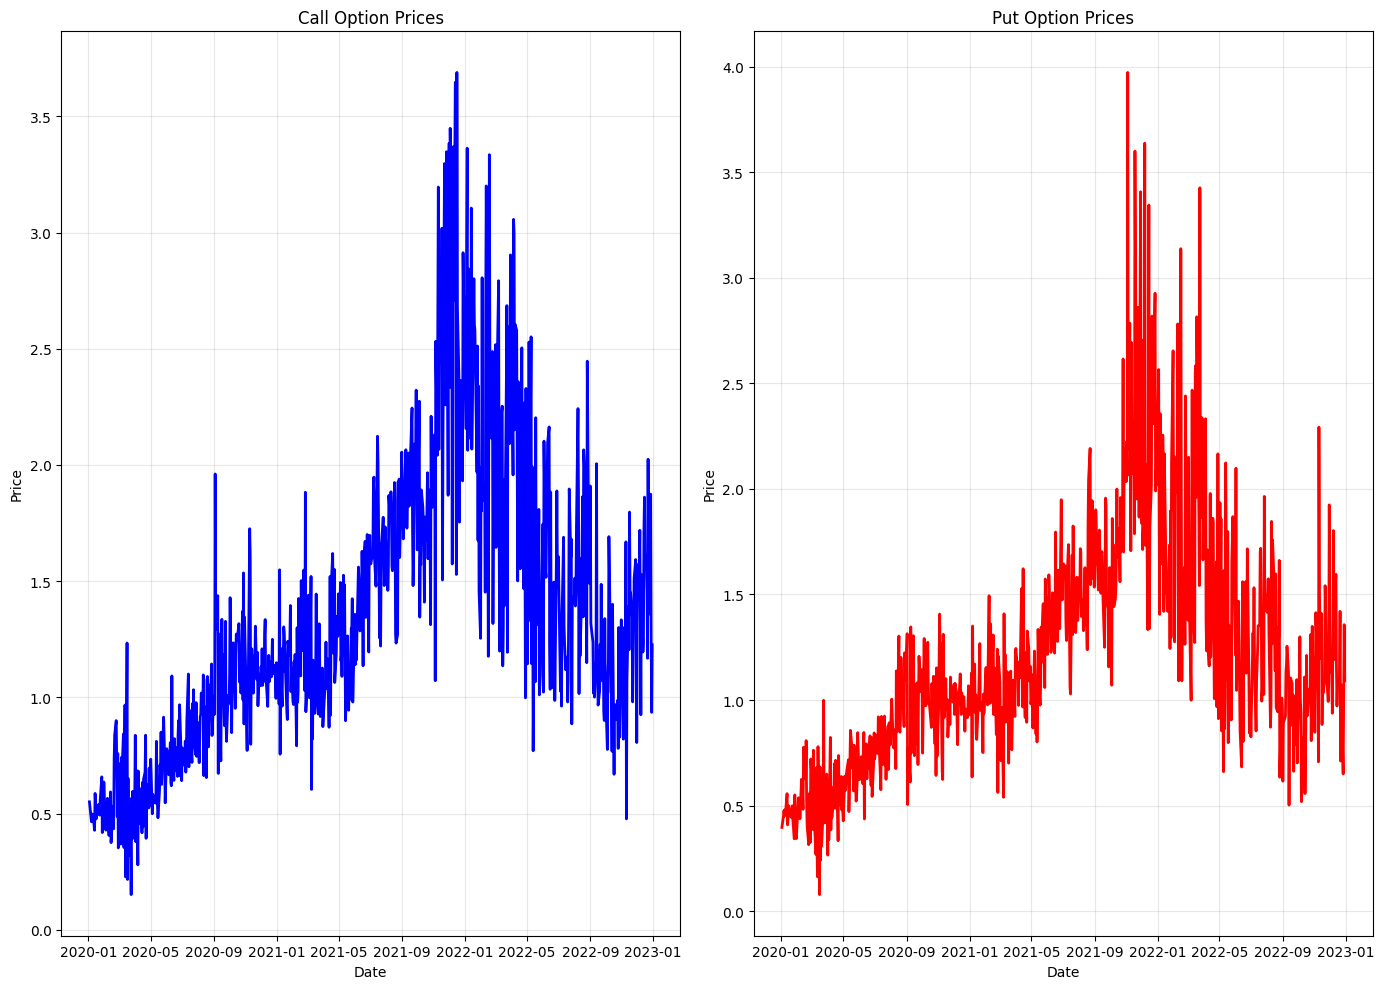

In [82]:
# Use the function to plot the option prices
plot_option_prices(dates, bs_call_prices, bs_put_prices, "Black-Scholes Option Prices for NVDA")

# Step 4 - calculate with Monte Carlo

In [83]:
def monte_carlo_option_pricing(S, K, T, r, sigma, option_type="call", num_simulations=10000, steps=252):
    dt = T / steps
    S_simulation = np.zeros((steps + 1, num_simulations))
    S_simulation[0] = S
    
    # Generate random paths
    z = np.random.standard_normal(num_simulations)

    for t in range(1, steps + 1):
        S_simulation[t] = S_simulation[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    
    # Calculate payoffs
    if option_type.lower() == "call":
        payoffs = np.maximum(S_simulation[-1] - K, 0)
    elif option_type.lower() == "put":
        payoffs = np.maximum(K - S_simulation[-1], 0)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")
    
    # Calculate option price
    option_price = np.exp(-r * T) * np.mean(payoffs) # mean of mpaytoffs is expected payoff
    
    return option_price

In [84]:
mc_call_prices = []
mc_put_prices = []

for i in range(1, len(data)):
    S = prices[i - 1]
    K = prices[i]

    mc_call_prices.append(monte_carlo_option_pricing(S, K, T, r, sigma, 'call'))
    mc_put_prices.append(monte_carlo_option_pricing(S, K, T, r, sigma, 'put'))

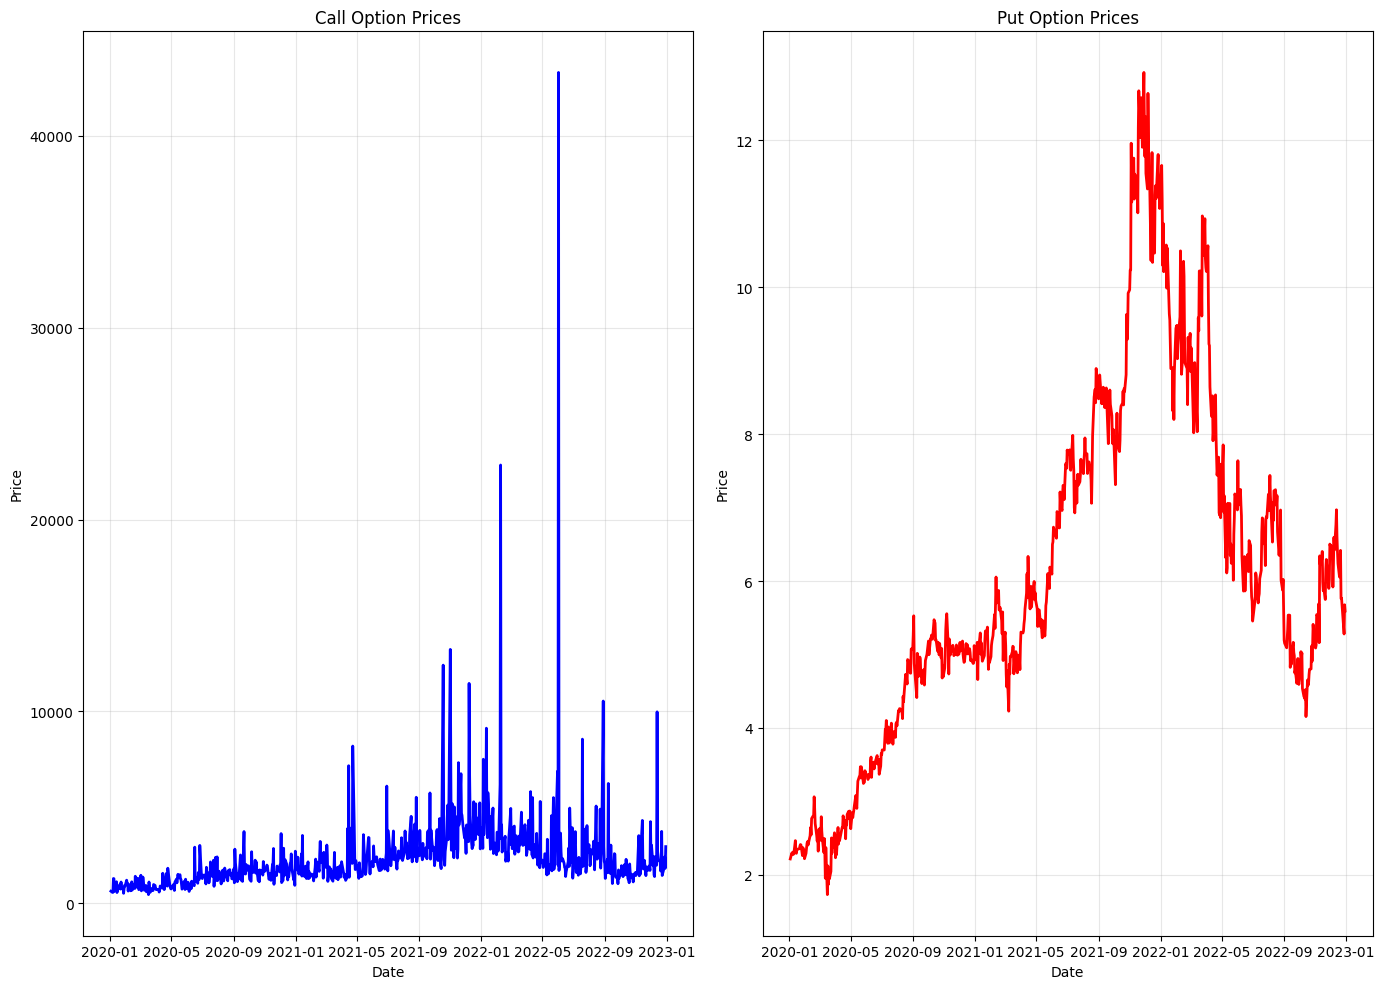

In [85]:
# Use the function to plot the option prices
plot_option_prices(dates, mc_call_prices, mc_put_prices, "Monte Carlo Option Prices for NVDA")

# Step 5 - compare Monte Carlo and Black Scholes

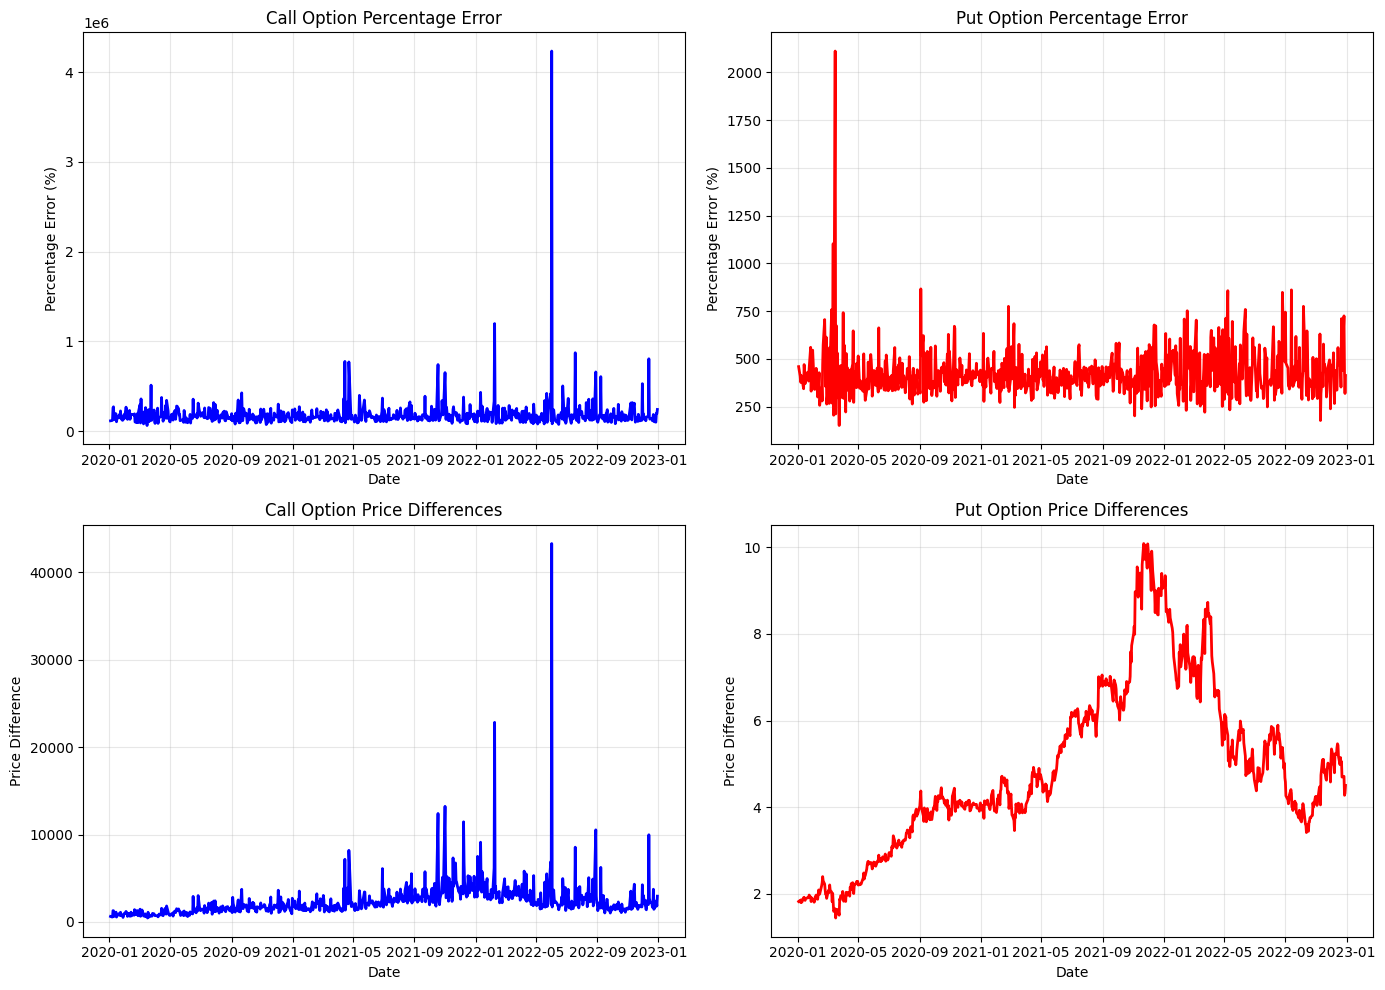

In [86]:
def plot_option_errors_and_differences(dates, call_percentage_error, put_percentage_error, call_price_diff, put_price_diff):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

    plot_line_chart(ax1, dates, call_percentage_error, 'Call Option Percentage Error', 'Date', 'Percentage Error (%)', 'blue')
    plot_line_chart(ax2, dates, put_percentage_error, 'Put Option Percentage Error', 'Date', 'Percentage Error (%)', 'red')
    
    plot_line_chart(ax3, dates, call_price_diff, 'Call Option Price Differences', 'Date', 'Price Difference', 'blue')
    plot_line_chart(ax4, dates, put_price_diff, 'Put Option Price Differences', 'Date', 'Price Difference', 'red')

    plt.tight_layout()
    plt.show()

call_price_diff = [mc - bs for mc, bs in zip(mc_call_prices, bs_call_prices)]
put_price_diff = [mp - bp for mp, bp in zip(mc_put_prices, bs_put_prices)]

call_percentage_error = [(mc - bs) / bs * 100 for mc, bs in zip(mc_call_prices, bs_call_prices)]
put_percentage_error = [(mp - bp) / bp * 100 for mp, bp in zip(mc_put_prices, bs_put_prices)]

plot_option_errors_and_differences(dates, call_percentage_error, put_percentage_error, call_price_diff, put_price_diff)

### Interpretation
The **call option price differences** and **percentage errors** show significant spikes, indicating that *Black-Scholes and Monte Carlo diverge* under certain conditions, likely due to volatility effects. 

The **put option price difference** closely follows the **stock price**, suggesting that *Monte Carlo captures real-world price dynamics better*, especially in put pricing. This implies that **Black-Scholes may not accurately reflect put option movements**, potentially due to *volatility skew* or *market-driven hedging effects*.


# Step 6 - discuss convergence and covariance reduction

Both **antithetic variates** and **control variates** can be used to improve the performance of Monte Carlo simulations for option pricing, but they work in different ways:  

- **Antithetic Variates:** Best used when the randomness in the simulation is *symmetric*, and you can create pairs of **negatively correlated paths**. This technique reduces variance by averaging the results of **inversely correlated random variables**, increasing the accuracy of estimates *without needing additional information*.  

- **Control Variates:** Best used when you have a **related random variable** for which the expectation is known. The goal is to **reduce variance** by leveraging the *correlation* between the variable of interest and the control variate. **Control variates require more thought** and sometimes need **additional problem-specific knowledge** (such as knowing the expectation of a related variable), but they often provide **more substantial variance reductions**.  
